I read some online tutorial articles as reference (https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet). I use the EDA part of the article and built my own model. My personal notebook can not precess data that is too big. Therefore I use VAR model instead of prophet.

Import some libraries.

In [1]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os 
import tarfile 
from pandas import datetime
%matplotlib inline
# statistics
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# prophet by Facebook
from fbprophet import Prophet
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings('ignore')

Read data and parse dates as times series.

In [2]:
#read data and parse dates as time series
train = pd.read_csv("/Users/rileychiu/Desktop/Kaggle/rossmann/train.csv",parse_dates = True,low_memory = False,index_col = 'Date')
test = pd.read_csv("/Users/rileychiu/Desktop/Kaggle/rossmann/test.csv",parse_dates = True)
submit = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/rossmann/sample_submission.csv')
store = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/rossmann/store.csv')
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [3]:
#train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])


# EDA

Take a look at train set.

In [4]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


Take a look at train set. No missing values. Total 1115 stores in 942 days.
942 *1115 = 1050330

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [7]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
train.nunique()

Store             1115
DayOfWeek            7
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

Then we look at the test set. There are missing values in "Open".
Total 856 stores in 48 days , but the max number of store is still 1115, some stores in between are missing.

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Filling the missing values of the test data. The "Open" information of store 622.

In [10]:
test.loc[test.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [11]:
test.loc[test.Store==622]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
3903,3904,622,7,2015-09-13,0.0,0,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0


In [12]:
test.loc[test.Open.isnull(),'Open']=test.loc[test.Open.isnull(),'Open'].fillna('1.0')

There are some examples without sales value in train set. We drop these examples while training.

In [13]:
#172871/1017209=17% no sales value
train[train.Sales==0].count()

Store            172871
DayOfWeek        172871
Sales            172871
Customers        172871
Open             172871
Promo            172871
StateHoliday     172871
SchoolHoliday    172871
dtype: int64

In [14]:
#172869/1017209 no customers value
train[train.Customers==0].count()

Store            172869
DayOfWeek        172869
Sales            172869
Customers        172869
Open             172869
Promo            172869
StateHoliday     172869
SchoolHoliday    172869
dtype: int64

In [15]:
#drop those data with no customers and no sales
train=train[(train.Customers!=0) & (train.Sales!=0)]

Adding new features.

In [16]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844338.000000
mean          9.493641
std           2.197448
min           2.749075
25%           7.895571
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

Look at the stores information. There are many missing values.

In [17]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [18]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


Fill these missing values.

In [19]:
# deal with distance missing value
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [20]:
#fill NAN = 0
store.fillna(0, inplace = True)

Join the train set and store set.

In [21]:
# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'left', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


Join the test set and store set.

In [22]:
# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
test_store = pd.merge(test, store, how = 'left', on = 'Store')

print("In total: ", test_store.shape)
test_store.head()

In total:  (41088, 17)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,3,4,2015-09-17,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0
3,4,8,4,2015-09-17,1,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
4,5,9,4,2015-09-17,1,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0


Look at how "StoreType" affect Sales.

In [23]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [24]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


In [25]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


Look at correlation.

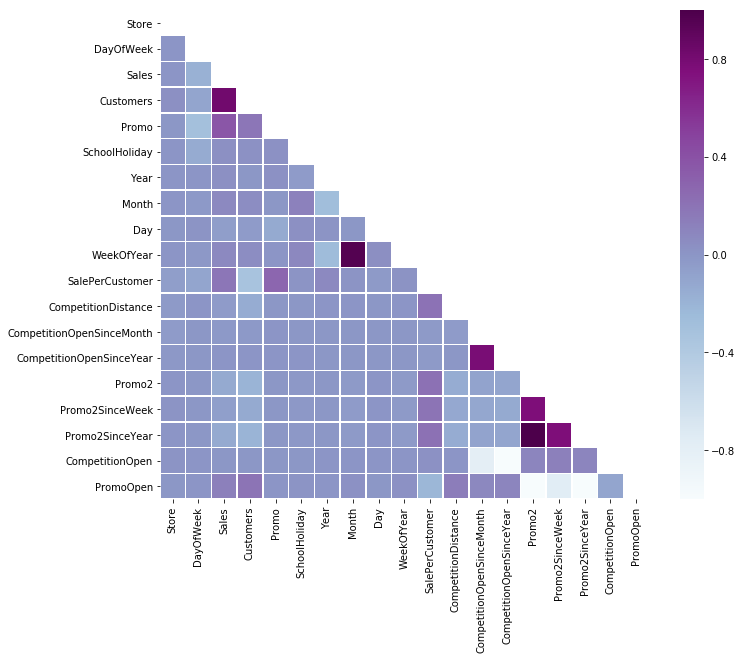

In [26]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

# Some conclusion from EDA.

The most selling and crowded StoreType is A. The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.
Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this StoreType generated the least amount of sales and customers over the whole period, it shows a great potential.

Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).
Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

In [27]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 24 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
Year                         844338 non-null int64
Month                        844338 non-null int64
Day                          844338 non-null int64
WeekOfYear                   844338 non-null int64
SalePerCustomer              844338 non-null float64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOp

## Feature Engineering

Now I want to create some features from the observation of EDA.

Store tye B has higher average sales than the other three.

Prom matters. Promo2 doesn't really matter.

Now we have some rough ideas about the data. We recreate the data again and perform feature engineering and modeling.

In [28]:
train = pd.read_csv("/Users/rileychiu/Desktop/Kaggle/rossmann/train.csv",parse_dates = True,low_memory = False)
submit = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/rossmann/sample_submission.csv')
store = pd.read_csv('/Users/rileychiu/Desktop/Kaggle/rossmann/store.csv')
train.index

RangeIndex(start=0, stop=1017209, step=1)

In [29]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [30]:
test.loc[test.Open.isnull(),'Open']=test.loc[test.Open.isnull(),'Open'].fillna('1.0')

In [31]:
train=train[(train.Customers!=0) & (train.Sales!=0)]

In [32]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [33]:
store.fillna(0, inplace = True)

In [34]:
train_store = pd.merge(train, store, how = 'left', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

In total:  (844338, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [35]:
test_store = pd.merge(test, store, how = 'left', on = 'Store')

print("In total: ", test_store.shape)
test_store.head()

In total:  (41088, 17)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,3,4,2015-09-17,1,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1,1,0,0,a,c,24000.0,4.0,2013.0,0,0.0,0.0,0
3,4,8,4,2015-09-17,1,1,0,0,a,a,7520.0,10.0,2014.0,0,0.0,0.0,0
4,5,9,4,2015-09-17,1,1,0,0,a,c,2030.0,8.0,2000.0,0,0.0,0.0,0


In [36]:
train_store.fillna(0, inplace = True)

In [37]:
train_store["DayOfWeek"]=train_store["DayOfWeek"].apply(str)

In [38]:
test_store["DayOfWeek"]=test_store["DayOfWeek"].apply(str)

Use one hot encoding to get the features that I want.

In [39]:
#one hot encoding
#temp=train_store['Sales','Customers','Open','Promo','StateHoliday','SchoolHoliday','CompetitionDistance']
train_store = pd.concat([train_store, pd.get_dummies(train_store[['StoreType','DayOfWeek']])],axis=1)


In [40]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 29 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null object
Date                         844338 non-null datetime64[ns]
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64

In [41]:
#one hot encoding
test_store = pd.concat([test_store, pd.get_dummies(test_store[['StoreType','DayOfWeek']])],axis=1)

In [42]:
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 28 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null object
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null object
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
StoreType_a     

## Select and train models + Fine-Tune hyperparameters

In this part, I will use regression models and time series model to predict and then take the average of each.

In the time series, I will use VAR model. And in the regression model, I will use stacking method with two layers.

In [43]:
Column_VAR=["Sales","Customers","Promo","SchoolHoliday","DayOfWeek_1","DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6"]

Column_regression=["Open","Promo","SchoolHoliday","CompetitionDistance","StoreType_b","DayOfWeek_1","DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]

In [44]:
train_store["Open"]=train_store["Open"].apply(float)
test_store["Open"]=test_store["Open"].apply(float)

In [45]:
frames=[]
for i in range(1,1116):
    store_i = train_store[train_store.Store == i]
    store_i_no_constants = store_i.loc[:, (store_i != store_i.iloc[0]).any()]
    store_i_no_constants = store_i_no_constants.sort_index(ascending = False)
    final_store_i_no_constants = store_i_no_constants.drop(['Date'], axis=1)
    final_store_i_no_constants.index = store_i_no_constants['Date']
    model = VAR(endog=final_store_i_no_constants[Column_VAR])
    model_fit = model.fit()
    # make prediction on validation
    prediction_i = model_fit.forecast(model_fit.y, steps=48)
    #converting predictions to dataframe
    pred_i = pd.DataFrame(index=range(0,len(prediction_i)),columns=[final_store_i_no_constants[Column_VAR].columns])
    for j in range(0,3):
        for k in range(0, len(prediction_i)):
           pred_i.iloc[k][j] = prediction_i[k][j]
    test_store_i = test[test.Store == i]
    test_store_i=test_store_i.sort_index(ascending = False)
    test_store_i["Date"].reset_index()["Date"]
    submit_store_i = pd.concat([test_store_i["Date"].reset_index()["Date"],pred_i["Sales"]], axis=1, join='outer')
    submit_store_i["Store"]=i
    frames.append(submit_store_i)
result = pd.concat(frames)
result['Store2']=1116-result['Store']

In [46]:
new_result=result.sort_values(by=['Date', 'Store2'],ascending=False)
new2_result=new_result.dropna().reset_index()
new2_result.head()

,index,Date,"(Sales,)",Store,Store2
0,47,2015-09-17,4863.75,1,1115
1,47,2015-09-17,6654.25,3,1113
2,47,2015-09-17,8562.96,7,1109
3,47,2015-09-17,4993.02,8,1108
4,47,2015-09-17,6711.06,9,1107


In [47]:
result_VAR = pd.DataFrame(index=range(0,len(new2_result)),columns=["Id","Sales"])
for j in range(0,2):
    for i in range(0, len(new2_result)):
        if j==0:
            result_VAR.iloc[i][j]=i+1
        if j==1:
            result_VAR.iloc[i][j] = new2_result.iloc[i][2]
result_VAR.head()

,Id,Sales
0,1,4863.75
1,2,6654.25
2,3,8562.96
3,4,4993.02
4,5,6711.06


Now we use the regression model.

In [48]:
X = train_store[Column_regression]
Y = train_store['Sales']

In [49]:
training, valid, ytraining, yvalid=train_test_split(X,Y,test_size=0.5)

In [50]:
model1=KNeighborsRegressor()
model1.fit(training,ytraining)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [51]:
model2=RandomForestRegressor()
model2.fit(training,ytraining)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [52]:
model3=LinearRegression()
model3.fit(training,ytraining)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
pred1=model1.predict(valid)
pred2=model2.predict(valid)
pred3=model3.predict(valid)

In [54]:
test_pred1=model1.predict(test_store[Column_regression])
test_pred2=model2.predict(test_store[Column_regression])
test_pred3=model3.predict(test_store[Column_regression])

In [55]:
stacked_pred=np.column_stack((pred1,pred2,pred3))
stacked_test_pred=np.column_stack((test_pred1,test_pred2,test_pred3))

In [56]:
meta_model=RandomForestRegressor()
meta_model.fit(stacked_pred,yvalid)
result_regression =meta_model.predict(stacked_test_pred)

In [57]:
result_regression

array([ 6909.47040899,  7946.0181371 ,  8936.82788278, ...,
        5458.53980714, 13037.66322129,  6313.05214286])

Combine the regression result and the VAR result.

In [58]:
final_result = pd.DataFrame({"Id": test_store['Id'], "Sales":(result_VAR["Sales"]+result_regression.astype(int))/2})
